In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from SALib import ProblemSpec
from seapopym.configuration.no_transport.parameter import ForcingParameters, ForcingUnit, KernelParameters
from dask.distributed import Client
import dask

from seapopym_optimization import wrapper

Load forcing.


In [2]:
time_start, time_end = "1998-01-01", "2022-01-01"

data = xr.open_dataset("../1_data_processing/1_1_Forcing/products/Bats_cmems.zarr", engine="zarr")
data["time"].attrs = {"axis": "T"}
data = data.sel(time=slice(time_start, time_end))
_ = data.load()

cafe_npp = xr.open_dataset("../1_data_processing/1_1_Forcing/products/Bats_cafe.zarr", engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(time_start, time_end))
cafe_npp = cafe_npp.dropna("time")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
_ = cafe_npp.load()

In [3]:
data

<xarray.Dataset> Size: 2MB
Dimensions:              (latitude: 1, longitude: 1, time: 8767, depth: 3)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * latitude             (latitude) float64 8B 31.6
  * longitude            (longitude) float64 8B -64.2
  * time                 (time) datetime64[ns] 70kB 1998-01-01 ... 2022-01-01
Data variables: (12/13)
    T                    (latitude, longitude, time, depth) float64 210kB 20....
    U                    (latitude, longitude, time, depth) float64 210kB 0.0...
    V                    (latitude, longitude, time, depth) float64 210kB -0....
    mnkc_epi             (latitude, longitude, time) float64 70kB 0.7326 ... ...
    mnkc_hmlmeso         (latitude, longitude, time) float64 70kB 0.6836 ... ...
    mnkc_lmeso           (latitude, longitude, time) float64 70kB 1.118 ... 1...
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 70kB 0.579 ... 1...
    mnkc_umeso           (latitude, longitude, time) float64 70kB 0.3336 ... ...
    npp                  (latitude, longitude, time) float64 70kB 450.0 ... 2...
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 210kB 100...
    zeu                  (latitude, longitude, time) float64 70kB 66.78 ... 7...
    zooc                 (latitude, longitude, time) float64 70kB 0.3742 ... ...

In [4]:
cafe_npp

<xarray.Dataset> Size: 140kB
Dimensions:    (time: 8767, latitude: 1, longitude: 1)
Coordinates:
  * latitude   (latitude) float64 8B 31.6
  * longitude  (longitude) float64 8B -64.2
  * time       (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2022-01-01
Data variables:
    CAFE       (time, latitude, longitude) float64 70kB 262.5 257.1 ... 228.4
Attributes:
    Conventions:  CF-1.8
    History:      2023-01-02 08:55:09.514113 Python
    Keywords:     Primary Production
    PI Contact:   tryankeogh@csir.co.za
    PI Name:      Thomas Ryan-Keogh

In [5]:
forcing_parameter_initial = ForcingParameters(
    temperature=ForcingUnit.from_dataset(forcing=data, name="T", resolution=0.08333, timestep=1),
    primary_production=ForcingUnit.from_dataset(cafe_npp, name="CAFE", resolution=0.08333, timestep=1),
)

2024-11-19 16:11:13,457 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



Generate initial conditions.


In [6]:
fg_parameters = wrapper.FunctionalGroupGeneratorNoTransport(
    [[10.38, -0.11, 150, 0.15, 1, 1, 0.1668]],
)
model = wrapper.model_generator_no_transport(
    fg_parameters=fg_parameters,
    forcing_parameters=forcing_parameter_initial,
    kernel_parameters=KernelParameters(compute_initial_conditions=True),
)
model.run()
initial_conditions = model.export_initial_conditions()

2024-11-19 16:11:13,474 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-11-19 16:11:13,477 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-11-19 16:11:13,483 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-11-19 16:11:13,562 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-11-19 16:11:13,577 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primary_production_helper.

2024-11-19 16:11:13,583 :: Seapodym ::  DEBUG ::
|	Direct computation for _min_temperature_by_cohort_helper.

2024-11-19 16:11:13,585 :: Seapodym ::  DEBUG ::
|	Direct computation for _mask_temperature_helper.

2024-11-19 16:11:13,591 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-11-19 16:11:13,617 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-11-19 16:11:13,622 :: Seapodym ::  DEBUG ::
|	Direct computation for _productio

Model generation used in sensibility analysis.


In [7]:
FORCING_PARAMETERS = ForcingParameters(
    temperature=ForcingUnit.from_dataset(data, name="T", resolution=0.08333, timestep=1),
    primary_production=ForcingUnit.from_dataset(cafe_npp, name="CAFE", resolution=0.08333, timestep=1),
    initial_condition_biomass=ForcingUnit.from_dataset(
        initial_conditions, name="initial_condition_biomass", resolution=0.08333, timestep=1
    ),
    initial_condition_production=ForcingUnit.from_dataset(
        initial_conditions, name="initial_condition_production", resolution=0.08333, timestep=1
    ),
)


def wrapper_model_generator_no_transport(fg_parameters):
    fg_parameters = wrapper.FunctionalGroupGeneratorNoTransport(np.array([fg_parameters]))
    return wrapper.model_generator_no_transport(
        fg_parameters=fg_parameters,
        forcing_parameters=FORCING_PARAMETERS,
    )

2024-11-19 16:11:17,063 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



Setup sensitivity analysis structure.


In [8]:
sp = ProblemSpec(
    {
        "names": [
            "energy_transfert",
            "tr_max",
            "tr_rate",
            "inv_lambda_max",
            "inv_lambda_rate",
        ],
        "groups": None,
        "bounds": [
            [0, 1],
            [0, 50],
            [-1, 0],
            [0, 1000],
            [0, 1],
        ],
        "outputs": ["Y"],
    }
)

Create the cost function.


In [9]:
@dask.delayed
def cost_function(x: np.ndarray, indices="mean"):
    energy_transfert, tr_max, tr_rate, inv_lambda_max, inv_lambda_rate = x.T
    fg_parameters = [tr_max, tr_rate, inv_lambda_max, inv_lambda_rate, 1, 1, energy_transfert]
    model = wrapper_model_generator_no_transport(fg_parameters)

    model.run()
    biomass_forcing = model.export_biomass()

    if indices == "mean":
        return float(biomass_forcing.mean())
    if indices == "var":
        return float(biomass_forcing.var())
    raise ValueError("indices must be mean or var")

# SOBOL SENSITIVITY ANALYSIS


In [11]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53007,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:53018,Total threads: 2
Dashboard: http://127.0.0.1:53021/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:53010,


In [25]:
SAMPLE_NUMBER = 10

# Mean biomasse value


In [26]:
param_values = sp.sample_sobol(SAMPLE_NUMBER)
res = [cost_function(param) for param in param_values.samples]
res = client.compute(res)
res = client.gather(res)
sp.set_results(np.asarray(res))

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
2024-11-19 16:17:42,491 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-11-19 16:17:42,493 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-11-19 16:17:42,495 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-11-19 16:17:42,496 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-11-19 16:17:42,498 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-11-19 16:17:42,501 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-11-19 16:17:42,501 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-11-19 16:17:42,503 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_f

Samples:
	5 parameters: ['energy_transfert', 'tr_max', 'tr_rate', 'inv_lambda_max', 'inv_lambda_rate']
	120 samples
Outputs:
	1 outputs: ['Y']
	120 evaluations


In [32]:
sp.analyze_sobol()
total_Si, first_Si, second_Si = sp.to_df()

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


<Figure size 640x480 with 0 Axes>

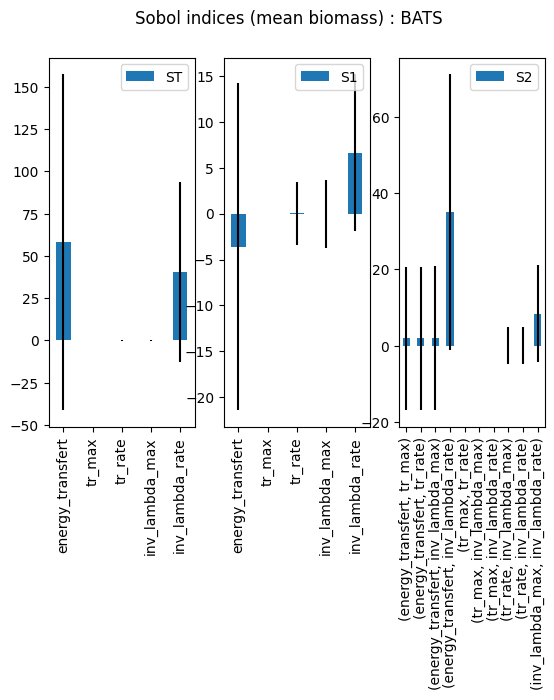

In [33]:
plt.figure()
ax = sp.plot()
plt.suptitle("Sobol indices (mean biomass) : BATS")
plt.show()

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


<Axes: title={'center': 'Sobol indices (mean biomass) : BATS'}>

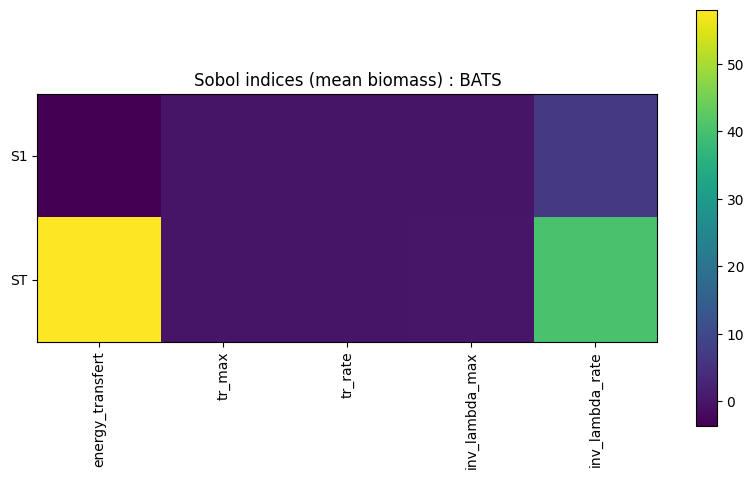

In [34]:
sp.heatmap(title="Sobol indices (mean biomass) : BATS")